#Abstract & Imports

The purpose of this notebook is as follows:


*   Perform an exploratory data analysis on Uber Pickup Data from certain months within the years 2014 & 2015 strictly within New York City to establish key understandings on pickup patterns and user/driver behavior
*   Leverage K-Means algorithm to form clusters within our dataset using pickup location features with the larger intention of defining "hot spots" for pickups throughout New York City
*   Leverage regression analysis for causal inference to estimate the sensitivity of taxi demand to Uber rides supply as well as analyzing market penetration for Uber within NYC



In [ ]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()

'/content'

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Uber/Data'

# About Our Data

Our data set was obtained through [FiveThirtyEight's Github](https://github.com/fivethirtyeight/uber-tlc-foil-response).

The repository contains data on over 4.5 million Uber pickups in NYC from April 2014 to September 2014, and 14.3 million more Uber pickups from January 2015 to June 2015.

One of the variables within the data set is **Base** which is the TLC base company code associated with Uber pickup.

A base station is a central facility which manages, organizes and/or dispatches for-hire vehicles.

*   A base station owner is any individual, partnership, corporation or other entity owning or operating a base station, including any individuals in a partnership or any entities owning ten percent or more of any such corporation or legal entity.
*   In NYC, for regulatory compliance, Uber drivers must be affiliated with a TLC-licensed base.
*   The 'Base' code in the dataset indicates which base the driver was operating under during the pickup.

The data is from all 5 boroughs within NYC: Brooklyn, Queens, Manhattan, Bronx, and Staten Island.

The monthly data from 2014 contains the following variables:

*   Date/Time = The date and time of the pickup
*   Lat = The Latitude of the pickup
*   Lon = The longitude of the pickup
*   Base = The TLC base company code affiliated with the Uber pickup

The monthly data from 2015 contains the following variables:

*   Dispatching_base_num = The TLC base company code of the base that dispatched the Uber
*   Pickup_date = The date and time of the pickup
*   Affiliated_base_num = The TLC base company code afiliated with the Uber pickup
*   locationID = The pickup location ID affiliated with the Uber pickup



# Exploring the Data

## 2015

In [ ]:
#Reading in the data
uber_2015_pickup_data = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2015', 'uber-raw-data-janjune-15.csv'))
uber_2015_pickup_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [ ]:
#Creating a datetime object using our Date column
uber_2015_pickup_data['Date'] = pd.to_datetime(uber_2015_pickup_data['Pickup_date']).dt.date
uber_2015_pickup_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date
0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17
1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17
2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17
3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17
4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17


In [ ]:
uber_2015_pickup_data.shape

(14270479, 5)

In [ ]:
uber_2015_pickup_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14270479 entries, 0 to 14270478
Data columns (total 5 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Dispatching_base_num  object
 1   Pickup_date           object
 2   Affiliated_base_num   object
 3   locationID            int64 
 4   Date                  object
dtypes: int64(1), object(4)
memory usage: 544.4+ MB


## 2014

In [ ]:
#2014 Data was spread out in multiple files, this will concatenate into one large DataFrame
uber_2014_pickup_data = []

for csv_path in os.listdir(os.path.join(data_path, 'Uber_Trip_Data_2014')):
  df = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2014', csv_path))
  uber_2014_pickup_data.append(df)
uber_2014_pickup_data = pd.concat(uber_2014_pickup_data, axis=0)

In [ ]:
uber_2014_pickup_data.head()

,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512


In [ ]:
uber_2014_pickup_data.shape

(4534327, 4)

In [ ]:
uber_2014_pickup_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


In [ ]:
#Checking for nulls
uber_2014_pickup_data.isna().sum()

,0
Date/Time,0
Lat,0
Lon,0
Base,0


In [ ]:
#Adding Date and Time features from datetime object before saving concatenated DataFrame
uber_2014_pickup_data['Date/Time'] = pd.to_datetime(uber_2014_pickup_data['Date/Time'], format='mixed')

uber_2014_pickup_data['Date'] = pd.to_datetime(pd.to_datetime(uber_2014_pickup_data['Date/Time']).dt.date)

uber_2014_pickup_data['Time'] = pd.to_datetime(uber_2014_pickup_data['Date/Time']).dt.time

uber_2014_pickup_data.head()

,Date/Time,Lat,Lon,Base,Date,Time
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,2014-06-01,00:00:00
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,2014-06-01,00:01:00
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,2014-06-01,00:04:00
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,2014-06-01,00:04:00
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,2014-06-01,00:07:00


In [ ]:
uber_2015_pickup_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date
0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17
1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17
2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17
3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17
4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17


# Exploratory Data Analysis

Goal: Create features within our datasets to better understand user behavior on the Uber app.

More specifically:


*   Uber pickup and distribution in New York City
*   Times when Uber pickups happen regularly
*   Days when Uber pickups happen regularly
*   Pickup distributions within zones



## Feature Engineering

In [ ]:
#This function can be called to add necessary datetime objects to each data set in order to explore the aformentioned areas of interest
def add_date_features(df, datetime_column):
  df[datetime_column] = pd.to_datetime(df[datetime_column])

  df['Month'] = df[datetime_column].dt.month
  df['Week'] = df[datetime_column].dt.isocalendar().week
  df['DayOfMonthNum'] = df[datetime_column].dt.day
  df['DayOfWeekNum'] = df[datetime_column].dt.dayofweek
  df['DayOfWeek'] = df[datetime_column].dt.day_name()
  df['Hour'] = df[datetime_column].dt.hour

  return df

In [ ]:
add_date_features(uber_2014_pickup_data, 'Date/Time')
add_date_features(uber_2015_pickup_data, 'Pickup_date')

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17,5,20,17,6,Sunday,9
1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17,5,20,17,6,Sunday,9
2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17,5,20,17,6,Sunday,9
3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17,5,20,17,6,Sunday,9
4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17,5,20,17,6,Sunday,9
...,...,...,...,...,...,...,...,...,...,...,...
14270474,B02765,2015-05-08 15:43:00,B02765,186,2015-05-08,5,19,8,4,Friday,15
14270475,B02765,2015-05-08 15:43:00,B02765,263,2015-05-08,5,19,8,4,Friday,15
14270476,B02765,2015-05-08 15:43:00,B02765,90,2015-05-08,5,19,8,4,Friday,15
14270477,B02765,2015-05-08 15:44:00,B01899,45,2015-05-08,5,19,8,4,Friday,15


In [ ]:
#Saving datasets so above steps do not have to be repeated
uber_2014_pickup_data.to_csv(os.path.join(data_path, 'Uber_Trip_Data_2014', 'uber-raw-data-2014-features.csv'), index=False)
uber_2015_pickup_data.to_csv(os.path.join(data_path, 'Uber_Trip_Data_2015', 'uber-raw-data-janjune-15-features.csv'), index=False)

In [ ]:
#Loading in datasets complete with all added datetime features
uber_2014_pickup_data = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2014', 'uber-raw-data-2014-features.csv'))
uber_2015_pickup_data = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2015', 'uber-raw-data-janjune-15-features.csv'))

In [ ]:
uber_2014_pickup_data.head()

,Date/Time,Lat,Lon,Base,Date,Time,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,2014-06-01,00:00:00,6,22,1,6,Sunday,0
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,2014-06-01,00:01:00,6,22,1,6,Sunday,0
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,2014-06-01,00:04:00,6,22,1,6,Sunday,0
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,2014-06-01,00:04:00,6,22,1,6,Sunday,0
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,2014-06-01,00:07:00,6,22,1,6,Sunday,0


In [ ]:
uber_2015_pickup_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17,5,20,17,6,Sunday,9
1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17,5,20,17,6,Sunday,9
2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17,5,20,17,6,Sunday,9
3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17,5,20,17,6,Sunday,9
4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17,5,20,17,6,Sunday,9


## Rides Per Month

<Axes: xlabel='Month'>

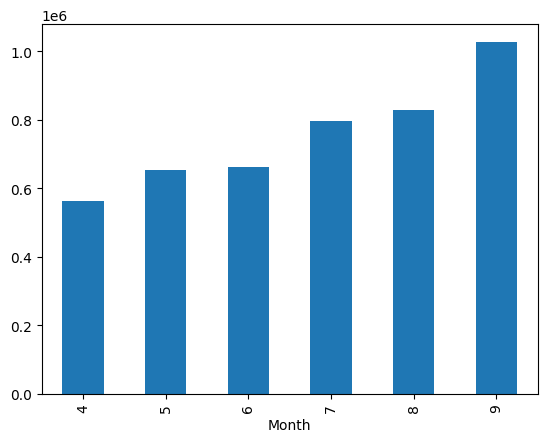

In [ ]:
uber_2014_pickup_data.groupby('Month')['Base'].count().plot(kind='bar')

<Axes: xlabel='Month'>

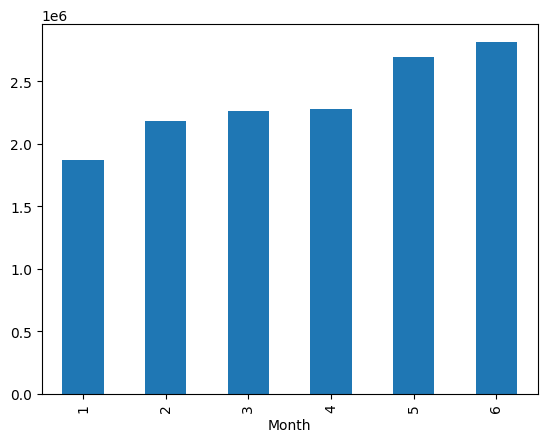

In [ ]:
uber_2015_pickup_data.groupby('Month')['Affiliated_base_num'].count().plot(kind='bar')

Points of note:


*   In both 2014 & 2015 Rides per month seems to grow month over month
*   In the 2014 dataset, September is the month with the most rides and in the 2015 dataset June is the month with the most rides
*   In the overlapping months (April, May, June) 2015 contains more pickup data points. This might be explained by Uber's growing platform and user base as the years pass. Considering they were founded in 2009 it's safe to say they were still growing in 2014/2015. This could also potentially explain month over month growth in rides within each respective dataset.
*   To gain some more insight it might be worthwhile to go even more granular with our exploration



## Rides Per Day

<Axes: xlabel='DayOfWeek'>

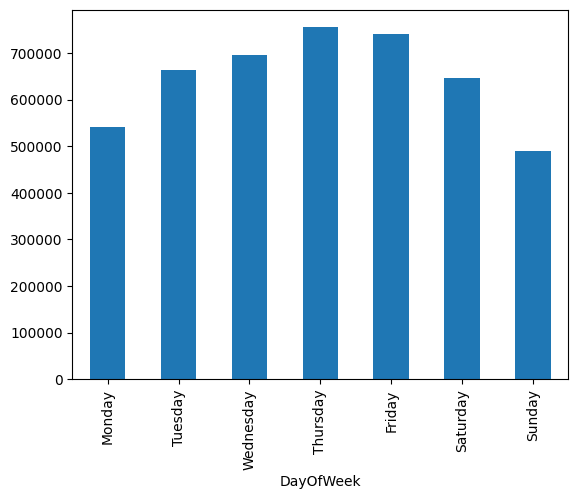

In [ ]:
uber_2014_pickup_data.groupby(['DayOfWeek', 'DayOfWeekNum'])['Base']\
.count()\
.sort_index(level='DayOfWeekNum')\
.droplevel(1, axis=0)\
.plot(kind='bar')

<Axes: xlabel='DayOfWeek'>

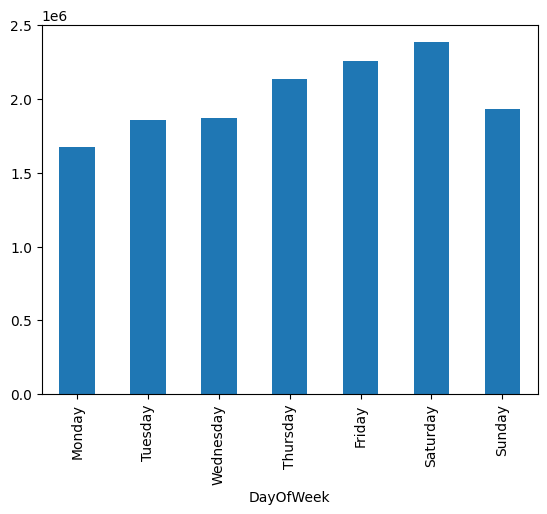

In [ ]:
uber_2015_pickup_data.groupby(['DayOfWeek', 'DayOfWeekNum'])['Affiliated_base_num']\
.count()\
.sort_index(level='DayOfWeekNum')\
.droplevel(1, axis=0)\
.plot(kind='bar')

Points of note:


*   In 2014 the rides by day grow with each day until Thursday we notice a peak and a subsequent falloff in the following days of the week. Common logic might dictate a peak on Saturday or Friday considering the weekend being days in which individuals are utilizing Uber more, however we don't see that here.
*   We do however see this expected pattern in the 2015 dataset, with a peak in activity on Saturdays after growing day over day.
*   It will most likely help to see how these visualizations change when looking at each month in specific.



## Rides Per Day Per Month

<Axes: xlabel='DayOfWeek'>

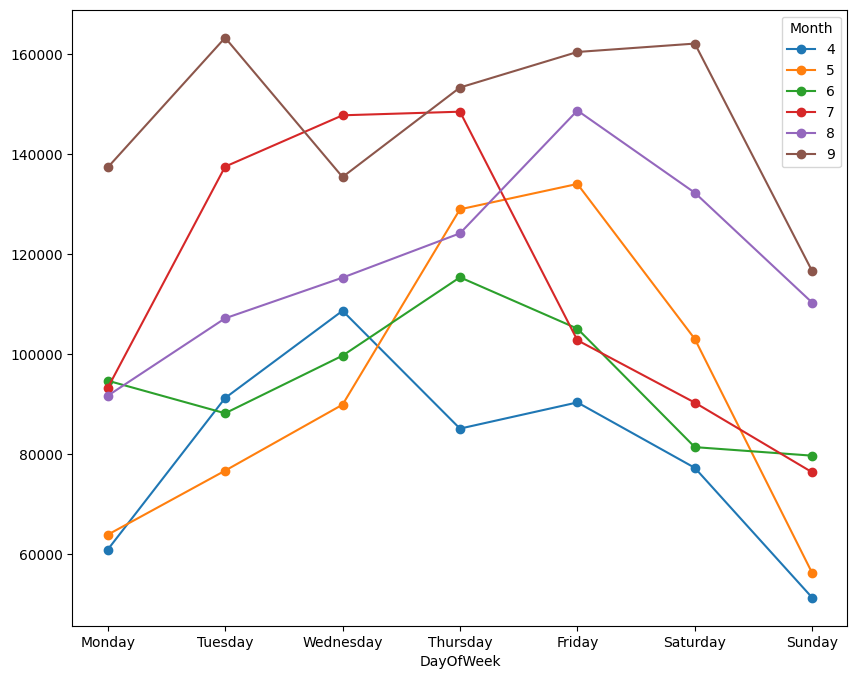

In [ ]:
uber_2014_pickup_data.groupby(['Month', 'DayOfWeekNum', 'DayOfWeek'])['Base']\
.count()\
.unstack(level='Month')\
.droplevel(0, axis=0)\
.plot(marker='o', figsize=(10,8))

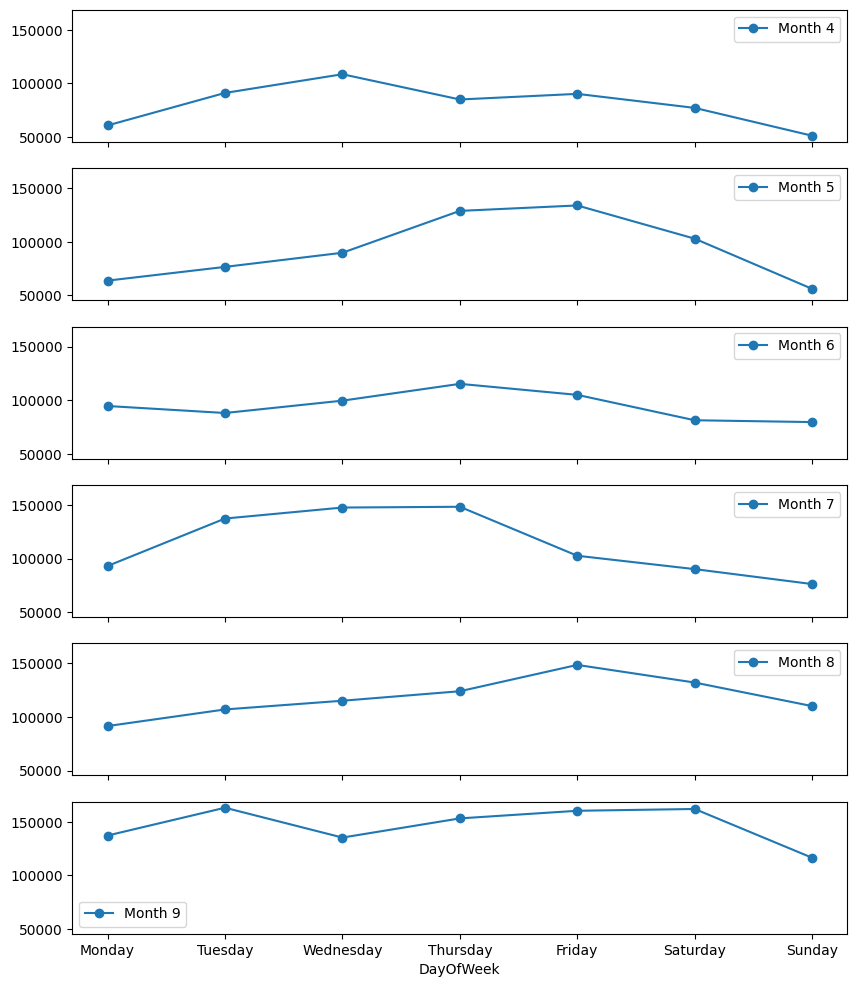

In [ ]:
df = uber_2014_pickup_data.groupby(['Month', 'DayOfWeekNum', 'DayOfWeek'])['Base']\
.count()\
.unstack(level='Month')\
.droplevel(0, axis=0)

fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()

for i in range(len(axs)):
  df.iloc[:, i].plot(marker='o', ax=axs[i], label=f'Month {df.iloc[:, i].name}', legend=True)

plt.show()

Points of Note:

*    There appears to be no set pattern across months other than the fact that one weekday shows a clear peak in activity.
*    We also observe what was observed earlier which is a clear increase in pickups month over month.

<Axes: xlabel='DayOfWeek'>

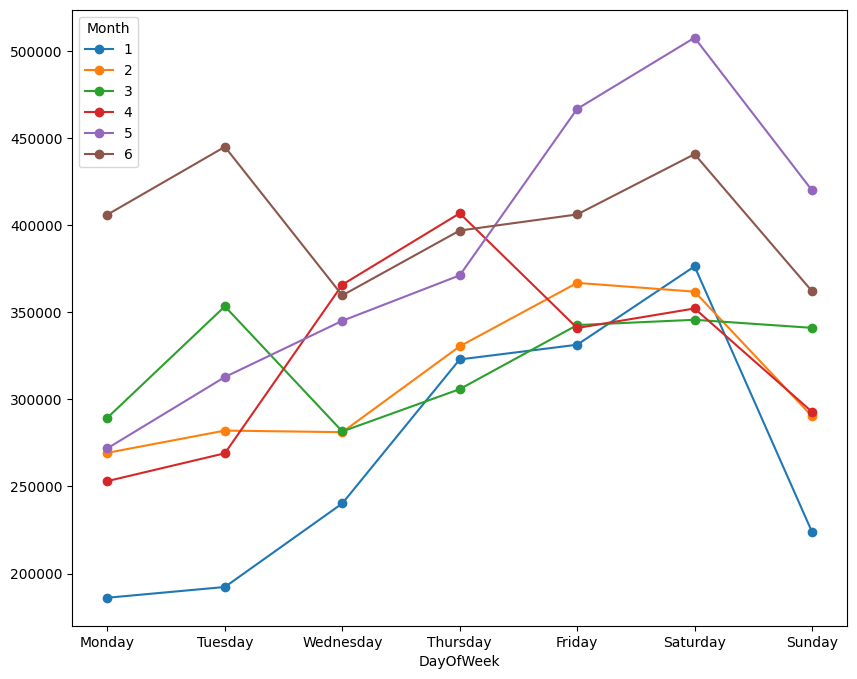

In [ ]:
uber_2015_pickup_data.groupby(['Month', 'DayOfWeekNum', 'DayOfWeek'])['Affiliated_base_num']\
.count()\
.unstack(level='Month')\
.droplevel(0, axis=0)\
.plot(marker = 'o', figsize=(10,8))

Points of note:

*    All months seem to be exhibiting a much more patterned display of activity with a strong peak on Saturdays throughout practically every month followed by a sharp dropoff on Sundays, similar to what we observed looking at all our data.
*    We also notice increase of rides month over month although it is not quite as explicit as in the 2014 data.

## Rides Per Hour

<Axes: xlabel='Hour'>

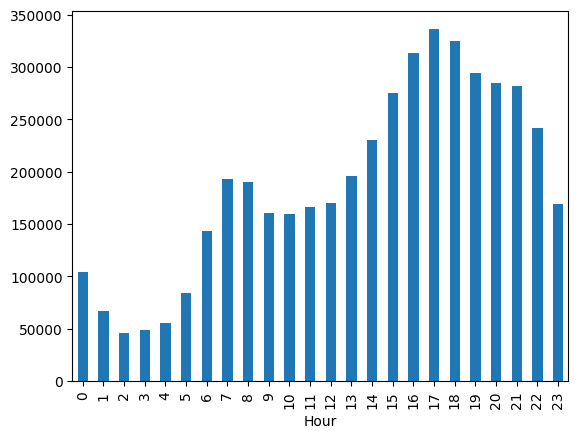

In [ ]:
uber_2014_pickup_data.groupby('Hour')['Base'].count().plot(kind='bar')

<Axes: xlabel='Hour'>

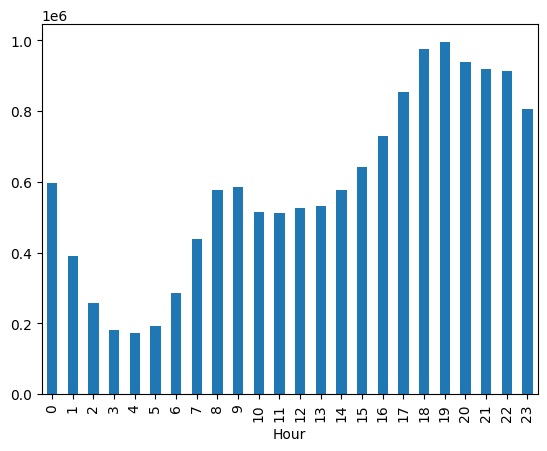

In [ ]:
uber_2015_pickup_data.groupby('Hour')['Affiliated_base_num'].count().plot(kind='bar')

Points of note:

*    We see very similar patterns between our two datasets showcasing very specific peaks and falloffs in activity throughout Hours.
*    This pattern might be explained looking at average daily schedules of New York City residents. Such as steady and significant increase from 5 p.m. to 7 p.m. being after work hours.
*    This pattern might change if we also observe specific days and months.

## Rides Per Hour, Per Day, Per Month

In [ ]:
#Create a dataframe to be used for visualizations with proper groupby
df = uber_2014_pickup_data.groupby(['Month', 'DayOfWeekNum', 'DayOfWeek', 'Hour'])['Base']\
.count()\
.unstack(level='Month')\
.droplevel(0, axis=0)\

df

Month              4     5     6     7     8     9
DayOfWeek Hour                                    
Monday    0      518   767   912  1260  1094  1885
          1      261   466   512   613   684  1201
          2      238   304   420   439   560   977
          3      571   627  1049  1019  1186  1780
          4     1021   977  1712  1615  1836  2479
...              ...   ...   ...   ...   ...   ...
Sunday    19    2579  2881  4163  3700  6195  6430
          20    2276  2782  4086  4012  5990  5930
          21    2310  2809  4285  3740  5659  5164
          22    1639  2230  3452  3291  4839  4115
          23    1018  1487  1872  2198  3265  2326

[168 rows x 6 columns]

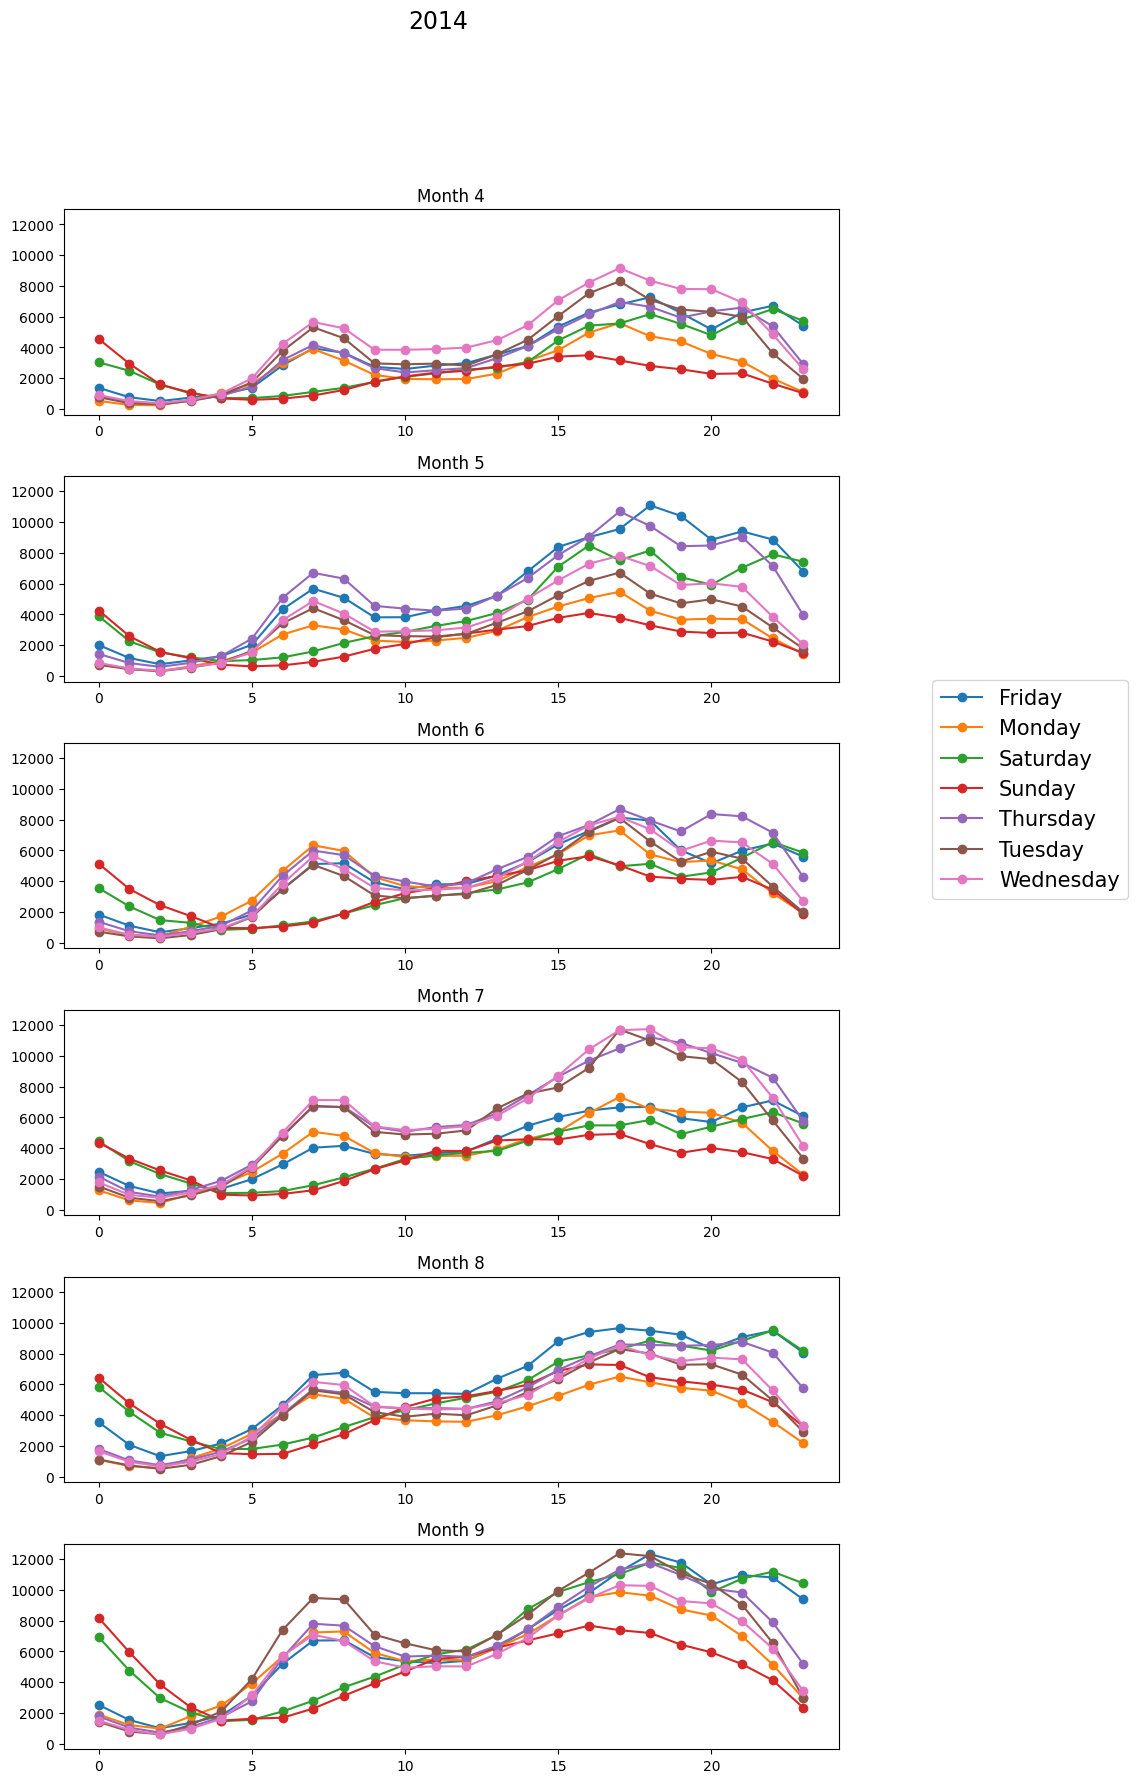

In [ ]:
fig, axs = plt.subplots(nrows = 6, ncols = 1, sharex=False, sharey=True, figsize=(10,20))
axs = axs.flatten()

for i in range(len(axs)):
  df.iloc[:,i].unstack(level='DayOfWeek').plot(marker='o', ax=axs[i], legend=False)
  axs[i].set_title(f'Month {df.iloc[:, i].name}')
  axs[i].set_xlabel('')

fig.legend(df.iloc[:, 0].unstack(level='DayOfWeek').columns, bbox_to_anchor=(1.2, .65), fontsize=15)
plt.suptitle('2014', fontsize=17)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
df = uber_2015_pickup_data.groupby(['Month', 'DayOfWeekNum', 'DayOfWeek', 'Hour'])['Affiliated_base_num']\
.count()\
.unstack(level='Month')\
.droplevel(0, axis=0)\

df

Month               1      2      3      4      5      6
DayOfWeek Hour                                          
Monday    0      4702   8975   7467   6256   9464  12569
          1      2727   4656   4250   3493   5456   7199
          2      1614   2875   2449   1881   3579   4250
          3      1271   2128   1877   1511   2584   3164
          4      2145   2524   3141   2750   3306   5079
...               ...    ...    ...    ...    ...    ...
Sunday    19    12265  16277  18567  15187  23896  17745
          20    10389  14449  17242  14997  22321  16150
          21     9792  13931  15631  13897  21228  18230
          22     9145  17729  14791  13276  20200  19995
          23     7197  12737  11567  10712  17615  18429

[168 rows x 6 columns]

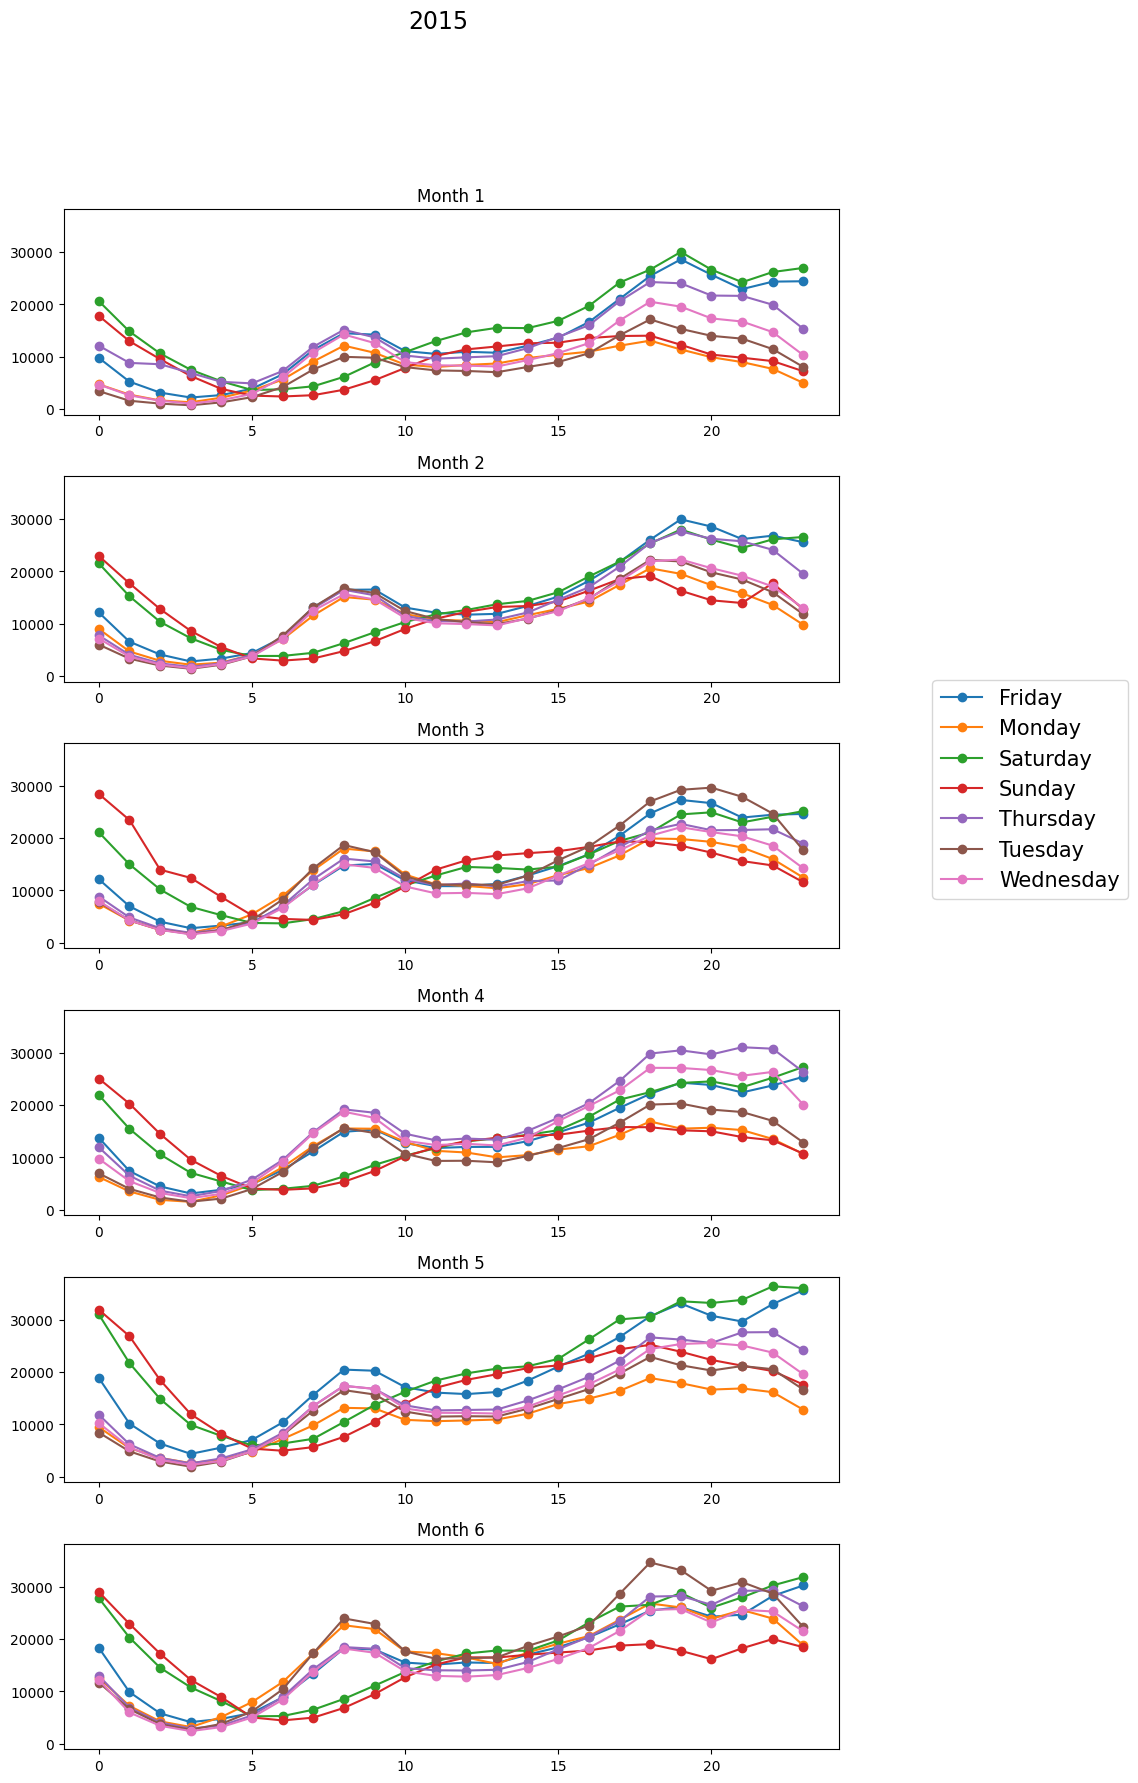

In [ ]:
fig, axs = plt.subplots(nrows = 6, ncols = 1, sharex=False, sharey=True, figsize=(10,20))
axs = axs.flatten()

for i in range(len(axs)):
  df.iloc[:,i].unstack(level='DayOfWeek').plot(marker='o', ax=axs[i], legend=False)
  axs[i].set_title(f'Month {df.iloc[:, i].name}')
  axs[i].set_xlabel('')

fig.legend(df.iloc[:, 0].unstack(level='DayOfWeek').columns, bbox_to_anchor=(1.2, .65), fontsize=15)
plt.suptitle('2015', fontsize=17)
plt.subplots_adjust(hspace=0.3)
plt.show()

Points of note:

*   It seems as if our patterns stay the same when observed on a daily and even monthly level with respect to the activity levels per hour. Peak hours seen before work and after work.
*   This appears to be a pretty robust pattern.

# Clustering

Because this data includes distinct variables primed for grouping, we want to employ the unsupervised learning model of Clustering to group our data and gain further understandings from it.

For the purposes of this Notebook, I have arbitrarily selected April as the month to be examined within clustering. Simply to reduce the size of our dataset.


## Elbow Test

In [ ]:
april_pickups = uber_2014_pickup_data[uber_2014_pickup_data['Month'] == 4]
april_pickups.shape

(564516, 12)

We have chosen to cluster the location features within our dataset (Latitude, Longitude) to be able to determine "hot spots" for Uber drivers to convene around in order to facilitate driver/rider matchings.

The first step in this process is to determine the number of clusters we would want to define. Normally we might be given a real life constraint that would determine this number such as cost, or resource constraint.

Since we aren't operating with any constraints we will find the optimal number of clusters for our dataset using the elbow method and use that number.

In [ ]:
from sklearn.cluster import KMeans

k_vals = range(2,11)

inertia = pd.DataFrame(columns=['Inertia', 'Average Cluster Inertia'])

for k in k_vals:
  k_means = KMeans(n_clusters = k, random_state=448)
  #Note: it would be normal to standardize our values before running the kmeans algorithm
  #however because we are dealing with latitude and longitude which are already standardized we do not need to
  k_means.fit(april_pickups[['Lat', 'Lon']])
  inertia.loc[k, 'Inertia'] = k_means.inertia_
  inertia.loc[k, 'Average Cluster Inertia'] = k_means.inertia_ / k

In [ ]:
inertia

,Inertia,Average Cluster Inertia
2,1355.951372,677.975686
3,1023.169031,341.056344
4,837.764976,209.441244
5,694.839282,138.967856
6,494.810845,82.468474
7,460.234063,65.747723
8,361.078179,45.134772
9,335.591524,37.287947
10,303.676784,30.367678


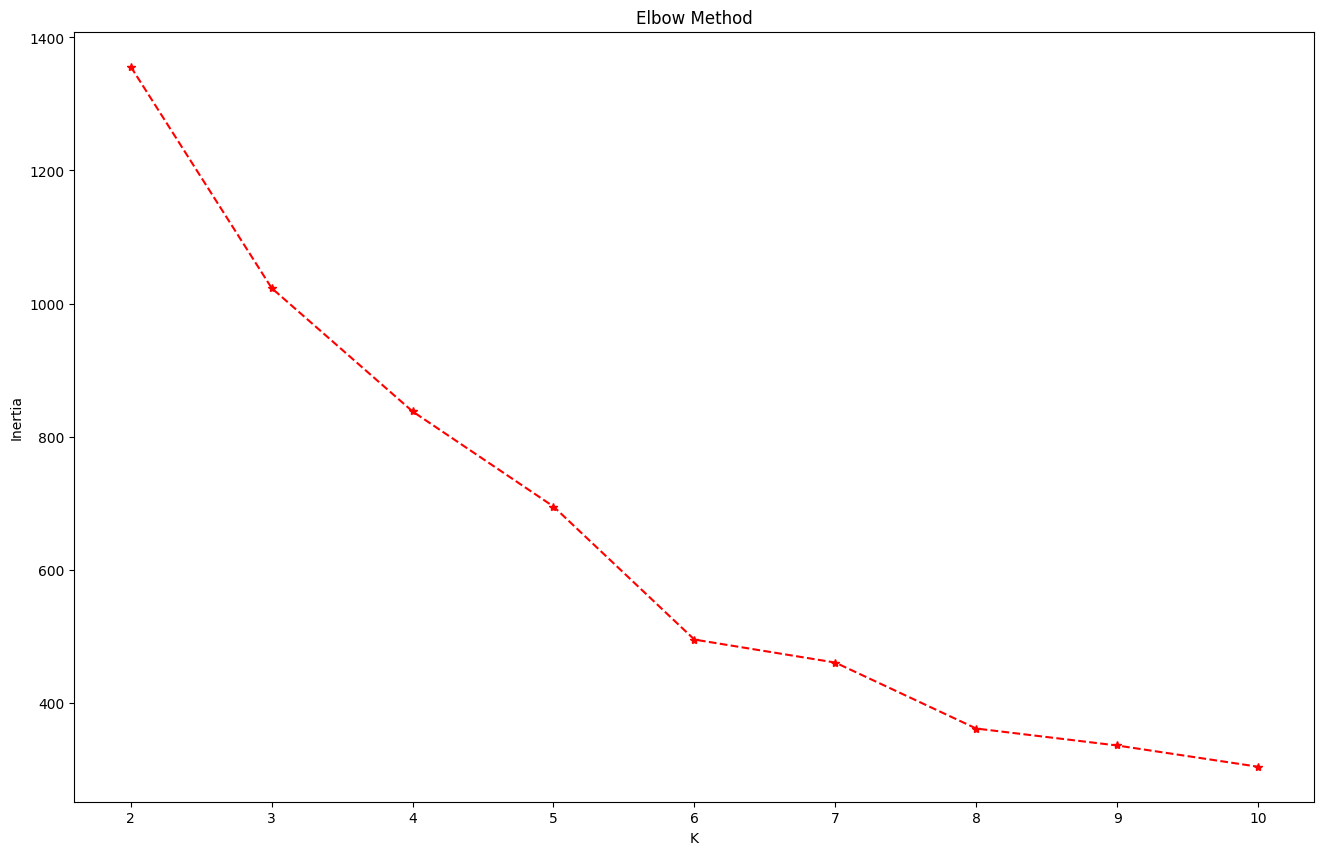

In [ ]:
inertia['Inertia'].plot(marker='*', figsize=(16,10), color='red', linestyle='--')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

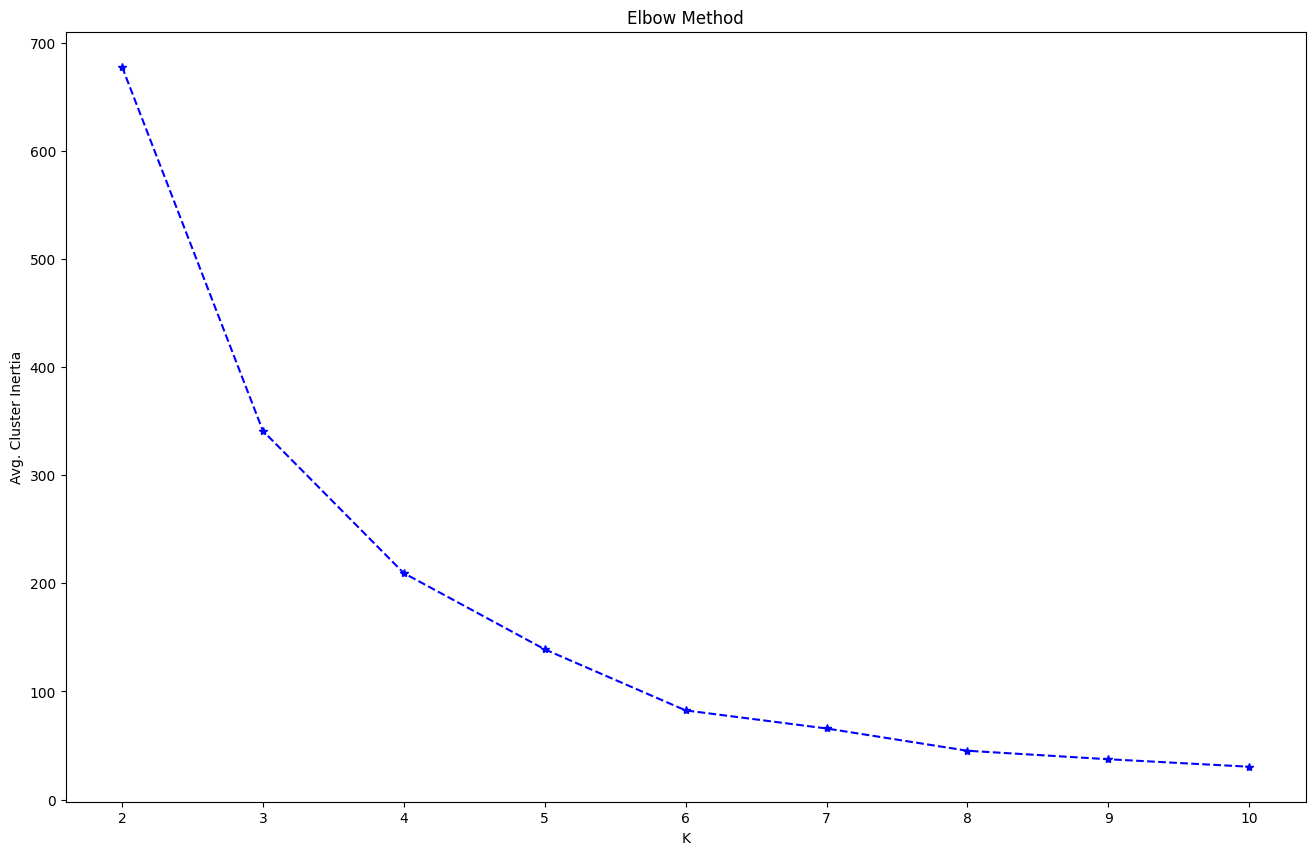

In [ ]:
inertia['Average Cluster Inertia'].plot(marker='*', figsize=(16,10), color='blue', linestyle='--')
plt.xlabel('K')
plt.ylabel('Avg. Cluster Inertia')
plt.title('Elbow Method')
plt.show()

Points of note:
*    Looking at our elbow test graph (1st graph) it seems as though 6 or 8 would be the ideal number of clusters
*    Our second graph looking at avg. of inertias across clusters confirms that 6 would most likely be the ideal number of clusters.

## K-Means Clustering

In [ ]:
#Instantiate our optimal K value for the KMeans algorithm
optimal_K = 6

k_means = KMeans(n_clusters = optimal_K)
k_means.fit(april_pickups[['Lat', 'Lon']])

#Add cluster number as a column in our original april pickups dataframe
april_pickups['Cluster'] = k_means.labels_

<ipython-input-34-c4c1efdf9fec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  april_pickups['Cluster'] = k_means.labels_


In [ ]:
april_pickups

,Date/Time,Lat,Lon,Base,Date,Time,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour,Cluster
1459965,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,00:11:00,4,14,1,1,Tuesday,0,0
1459966,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,00:17:00,4,14,1,1,Tuesday,0,1
1459967,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,00:21:00,4,14,1,1,Tuesday,0,1
1459968,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,00:28:00,4,14,1,1,Tuesday,0,0
1459969,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,00:33:00,4,14,1,1,Tuesday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024476,2014-04-30 23:22:00,40.7640,-73.9744,B02764,2014-04-30,23:22:00,4,18,30,2,Wednesday,23,0
2024477,2014-04-30 23:26:00,40.7629,-73.9672,B02764,2014-04-30,23:26:00,4,18,30,2,Wednesday,23,0
2024478,2014-04-30 23:31:00,40.7443,-73.9889,B02764,2014-04-30,23:31:00,4,18,30,2,Wednesday,23,1
2024479,2014-04-30 23:32:00,40.6756,-73.9405,B02764,2014-04-30,23:32:00,4,18,30,2,Wednesday,23,2


In [ ]:
#These will be our defined 'hot spots'
cluster_centers = pd.DataFrame(k_means.cluster_centers_, columns=['Latitude', 'Longitude'])

cluster_centers

,Latitude,Longitude
0,40.765630,-73.972766
1,40.731188,-73.998571
2,40.688623,-73.965578
3,40.659495,-73.774045
4,40.700541,-74.201673
5,40.798031,-73.868623


## Hot Spot Visualization & Interpretation

<Axes: xlabel='Lat', ylabel='Lon'>

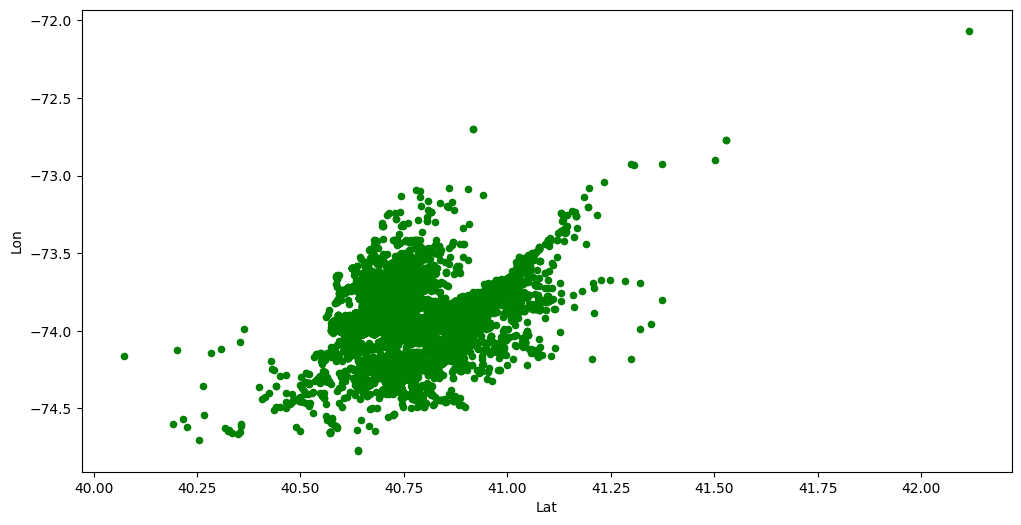

In [ ]:
#Showcases all data points within our april dataframe
april_pickups.plot(kind='scatter',
                   x='Lat',
                   y='Lon',
                   color='green',
                   figsize=(12,6))

In [ ]:
from matplotlib import cm

normalized_labels = k_means.labels_ / k_means.labels_.max()
cmap = cm.rainbow(normalized_labels)

<Axes: xlabel='Lat', ylabel='Lon'>

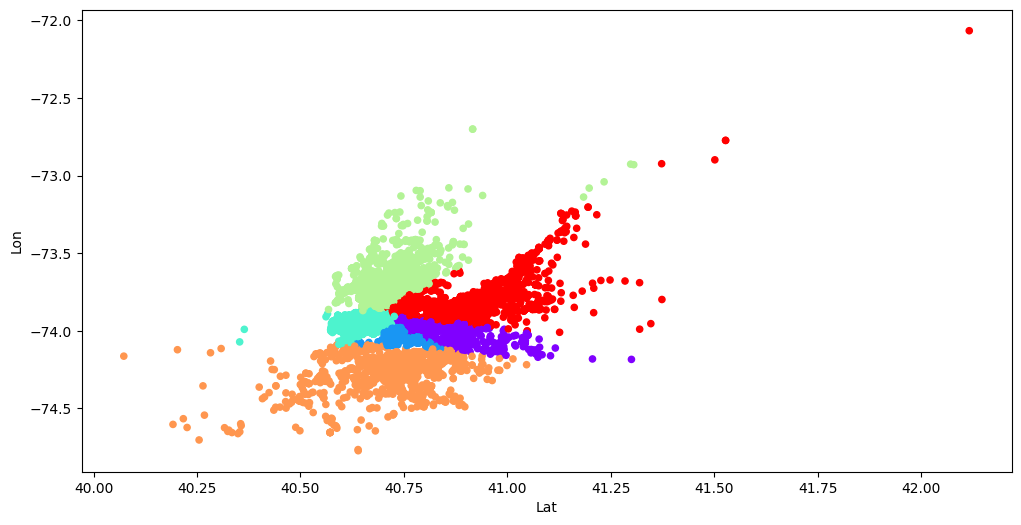

In [ ]:
#Color coded data points based off which cluster they are a part of to visualize cluster assignments
april_pickups.plot(kind='scatter',
                   x='Lat',
                   y='Lon',
                   color=cmap,
                   figsize=(12,6))

<Axes: xlabel='Latitude', ylabel='Longitude'>

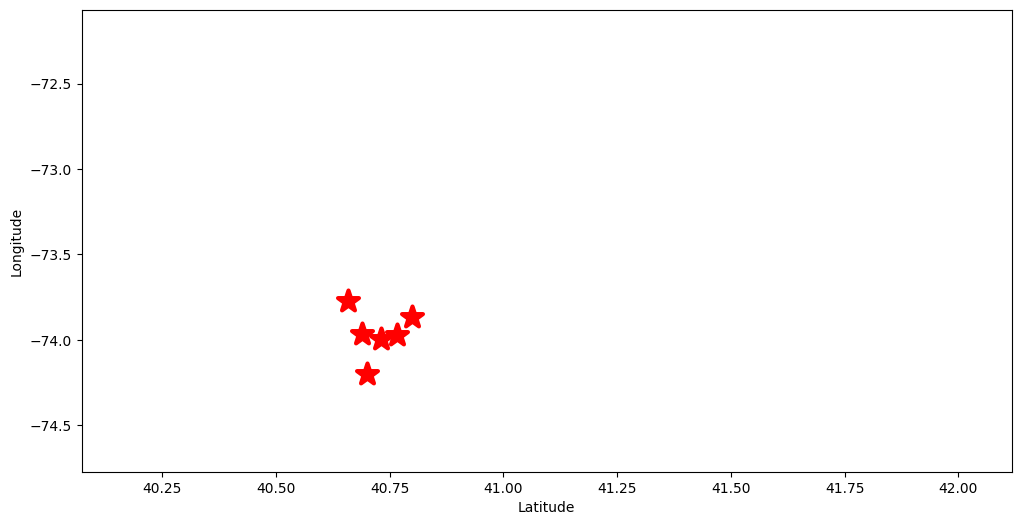

In [ ]:
#Visualizes our cluster centers
cluster_centers.plot(kind='scatter',
                     x='Latitude',
                     y='Longitude',
                     marker='*',
                     color='red',
                     s=250,
                     linewidth=3,
                     xlim=[april_pickups['Lat'].min(), april_pickups['Lat'].max()],
                     ylim=[april_pickups['Lon'].min(), april_pickups['Lon'].max()],
                     figsize=(12,6))

<Axes: xlabel='Latitude', ylabel='Longitude'>

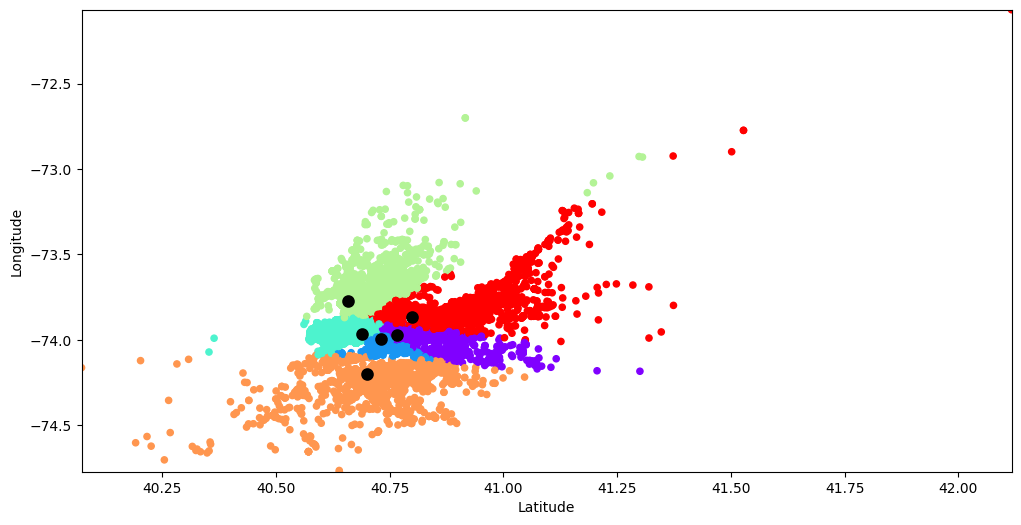

In [ ]:
#Puts everything together into one visualization
fig = april_pickups.plot(kind='scatter',
                   x='Lat',
                   y='Lon',
                   color=cmap,
                   figsize=(12,6))

cluster_centers.plot(kind='scatter',
                     x='Latitude',
                     y='Longitude',
                     marker='.',
                     color='black',
                     s=200,
                     linewidth=2,
                     xlim=[april_pickups['Lat'].min(), april_pickups['Lat'].max()],
                     ylim=[april_pickups['Lon'].min(), april_pickups['Lon'].max()],
                     figsize=(12,6),
                     ax=fig)

In [ ]:
#The folium package will allow us to visualize our clusters with real life context
#On a map of NYC
import folium

k_means.cluster_centers_

array([[ 40.76563013, -73.97276601],
       [ 40.7311878 , -73.99857109],
       [ 40.68862264, -73.96557771],
       [ 40.65949497, -73.77404482],
       [ 40.7005414 , -74.20167303],
       [ 40.79803106, -73.8686226 ]])

In [ ]:
centroid = k_means.cluster_centers_.tolist()
centroid

[[40.765630126652624, -73.97276600754822],
 [40.73118780450761, -73.99857109261029],
 [40.68862264465288, -73.96557771187712],
 [40.65949496562738, -73.77404481633221],
 [40.70054140415895, -74.20167302861849],
 [40.79803105651878, -73.86862260227332]]

In [ ]:
map_ = folium.Map(location=centroid[0], zoom_start=10)

for center in centroid:
  folium.Marker(location=center, popup=center).add_to(map_)

map_

<Axes: xlabel='Cluster'>

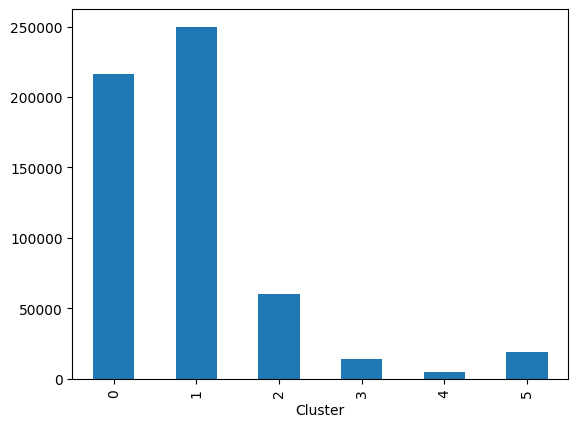

In [ ]:
april_pickups.loc[:,'Cluster'].value_counts().sort_index().plot(kind='bar')

Our visualizations allow us to observe the spread of the clusters as well as how populated each cluster is.

We can now use KMeans predict on a new pickup request for it to be assigned to an established cluster and therefore sent to a driver located at that cluster's respective hot spot. This should enhance rider/driver matching efficiency.

Uber could also incentivize drivers through their pricing mechanisms to stay around these hot spots.

## Shortcomings & Areas for Additional Examination

There would need to be some additional housekeeping done in our specific analysis considering one of our defined hot spots (cluster 5's centroid) is located in the East River. This brings up a general problem with our clustering. The solution would be to set constraints defining land that would impact cluster distributions and therefore cluster centroids.

Another area to improve this analysis would involve clustering with respect to our various time features. Uber could make the hot spots dynamic so that they are changing with respect to the month, day or even the hour making them even more efficient.

# Regression Analysis

We also want to analyze how Uber might be able to improve their market share in an essential market that is New York City that is also flooded with taxis.

What we can do is implement a system that monitors how supply of Ubers within NYC impacts the demand of taxi rides taken.

## Creating Our Data

In [ ]:
#Creating a new function to add datetime features because our last one was not comprehensive enough
def add_more_date_features(df, datetime_column):
  df[datetime_column] = pd.to_datetime(df[datetime_column])
  df['Date'] = df[datetime_column].dt.date
  df['Month'] = df[datetime_column].dt.month
  df['Week'] = df[datetime_column].dt.isocalendar().week
  df['DayOfMonthNum'] = df[datetime_column].dt.day
  df['DayOfWeekNum'] = df[datetime_column].dt.dayofweek
  df['DayOfWeek'] = df[datetime_column].dt.day_name()
  df['Hour'] = df[datetime_column].dt.hour
  return df

In [ ]:
#Choosing to work on just June 2015 data out of simplicity
green_cab_June_2015 = pd.read_parquet(os.path.join(data_path, 'NYC_TLC_Cab_Trip_Records', 'green_tripdata_2015-06.parquet'))

green_cab_June_2015 = add_more_date_features(green_cab_June_2015, 'lpep_pickup_datetime')

green_cab_June_2015

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,2,2015-06-01 00:18:37,2015-06-01 00:37:36,N,1,97,112,1,5.50,20.0,...,1,1.0,None,2015-06-01,6,23,1,0,Monday,0
1,2,2015-06-01 00:19:26,2015-06-01 00:21:32,N,1,80,80,1,0.35,3.5,...,1,1.0,None,2015-06-01,6,23,1,0,Monday,0
2,2,2015-06-01 00:26:41,2015-06-01 00:42:13,N,1,80,90,1,4.42,16.0,...,1,1.0,None,2015-06-01,6,23,1,0,Monday,0
3,2,2015-06-01 00:13:36,2015-06-01 00:22:42,N,1,225,97,1,2.20,9.5,...,1,1.0,None,2015-06-01,6,23,1,0,Monday,0
4,2,2015-06-01 00:24:47,2015-06-01 00:46:14,N,1,97,63,1,4.81,18.0,...,2,1.0,None,2015-06-01,6,23,1,0,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638863,2,2015-06-30 23:41:57,2015-07-01 00:04:37,N,1,223,164,1,5.37,20.5,...,1,1.0,None,2015-06-30,6,27,30,1,Tuesday,23
1638864,2,2015-06-30 23:28:05,2015-06-30 23:40:49,N,1,97,112,1,3.62,12.5,...,1,1.0,None,2015-06-30,6,27,30,1,Tuesday,23
1638865,2,2015-06-30 23:20:05,2015-06-30 23:27:22,N,1,25,52,1,1.11,7.0,...,2,1.0,None,2015-06-30,6,27,30,1,Tuesday,23
1638866,2,2015-06-30 23:29:13,2015-06-30 23:39:40,N,1,40,106,1,1.75,9.0,...,1,1.0,None,2015-06-30,6,27,30,1,Tuesday,23


In [ ]:
yellow_cab_June_2015 = pd.read_parquet(os.path.join(data_path, 'NYC_TLC_Cab_Trip_Records', 'yellow_tripdata_2015-06.parquet'))

yellow_cab_June_2015 = add_more_date_features(yellow_cab_June_2015, 'tpep_pickup_datetime')

yellow_cab_June_2015

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,airport_fee,Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,1,2015-06-01 00:04:04,2015-06-01 00:13:02,1,1.10,1,N,79,148,3,...,8.80,None,None,2015-06-01,6,23,1,0,Monday,0
1,1,2015-06-01 00:42:13,2015-06-01 00:52:37,1,3.40,1,N,87,68,1,...,14.80,None,None,2015-06-01,6,23,1,0,Monday,0
2,1,2015-06-01 00:24:29,2015-06-01 00:50:18,4,5.40,1,N,164,7,1,...,24.30,None,None,2015-06-01,6,23,1,0,Monday,0
3,1,2015-06-01 00:11:03,2015-06-01 00:19:47,1,2.80,1,N,163,24,1,...,13.55,None,None,2015-06-01,6,23,1,0,Monday,0
4,1,2015-06-01 00:20:29,2015-06-01 00:52:44,1,19.60,2,N,132,151,2,...,58.34,None,None,2015-06-01,6,23,1,0,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12324931,2,2015-06-30 23:09:08,2015-06-30 23:39:43,1,17.63,1,N,132,49,2,...,50.30,None,None,2015-06-30,6,27,30,1,Tuesday,23
12324932,1,2015-06-30 23:24:42,2015-06-30 23:33:50,2,1.80,1,N,230,237,2,...,9.80,None,None,2015-06-30,6,27,30,1,Tuesday,23
12324933,1,2015-06-30 23:41:39,2015-06-30 23:45:18,1,0.80,1,N,230,142,1,...,8.15,None,None,2015-06-30,6,27,30,1,Tuesday,23
12324934,2,2015-06-30 23:07:30,2015-06-30 23:26:44,2,7.14,1,N,230,244,1,...,29.16,None,None,2015-06-30,6,27,30,1,Tuesday,23


In [ ]:
uber_2015_pickup_data = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2015', 'uber-raw-data-janjune-15.csv'))

uber_2015_pickup_data = add_more_date_features(uber_2015_pickup_data, 'Pickup_date')

uber_June_2015 = uber_2015_pickup_data[uber_2015_pickup_data['Month'] == 6].reset_index(drop=True)

uber_June_2015

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,B02682,2015-06-16 17:03:00,B02682,114,2015-06-16,6,25,16,1,Tuesday,17
1,B02682,2015-06-16 17:03:00,B02682,151,2015-06-16,6,25,16,1,Tuesday,17
2,B02682,2015-06-16 17:03:00,B02682,4,2015-06-16,6,25,16,1,Tuesday,17
3,B02682,2015-06-16 17:03:00,B02682,211,2015-06-16,6,25,16,1,Tuesday,17
4,B02682,2015-06-16 17:03:00,B02682,238,2015-06-16,6,25,16,1,Tuesday,17
...,...,...,...,...,...,...,...,...,...,...,...
2816890,B02836,2015-06-30 22:51:00,B02836,143,2015-06-30,6,27,30,1,Tuesday,22
2816891,B02836,2015-06-30 22:52:00,B02836,90,2015-06-30,6,27,30,1,Tuesday,22
2816892,B02836,2015-06-30 23:06:00,B02836,246,2015-06-30,6,27,30,1,Tuesday,23
2816893,B02836,2015-06-30 23:20:00,B02836,107,2015-06-30,6,27,30,1,Tuesday,23


In [ ]:
rain_data = pd.read_csv(os.path.join(data_path, 'Weather_Data_in_NYC', 'NYC_precipitation_data.csv'))

rain_data = add_more_date_features(rain_data, 'Date/Time')

rain_June_2015 = rain_data[(rain_data['Month']==6) & (rain_data['Date/Time'].dt.year==2015)]

rain_June_2015

,Date/Time,LocationID,Latitude,Longitude,Reflectivity (dBZ),Radial Velocity (m/s),Spectrum Width (m/s),Precipitation (mm),Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
10224,2015-06-01 00:00:00,1,40.689515,-74.176779,52.746531,-11.270298,5.808091,47.139165,2015-06-01,6,23,1,0,Monday,0
10225,2015-06-01 01:00:00,1,40.689515,-74.176779,49.247218,13.036897,4.237091,46.457973,2015-06-01,6,23,1,0,Monday,1
10226,2015-06-01 02:00:00,1,40.689515,-74.176779,33.373085,-17.999365,6.289803,36.578739,2015-06-01,6,23,1,0,Monday,2
10227,2015-06-01 03:00:00,1,40.689515,-74.176779,40.867611,-2.395680,7.616121,43.664248,2015-06-01,6,23,1,0,Monday,3
10228,2015-06-01 04:00:00,1,40.689515,-74.176779,34.671637,-14.082607,8.018309,32.641758,2015-06-01,6,23,1,0,Monday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845175,2015-06-30 18:00:00,262,40.899080,-73.856400,27.833455,-24.941525,8.733788,14.566159,2015-06-30,6,27,30,1,Tuesday,18
2845176,2015-06-30 19:00:00,262,40.899080,-73.856400,46.157816,-22.333975,9.866792,33.145581,2015-06-30,6,27,30,1,Tuesday,19
2845177,2015-06-30 20:00:00,262,40.899080,-73.856400,40.665249,20.652073,10.561636,60.443943,2015-06-30,6,27,30,1,Tuesday,20
2845178,2015-06-30 21:00:00,262,40.899080,-73.856400,37.028299,3.257083,7.509054,42.758005,2015-06-30,6,27,30,1,Tuesday,21


In [ ]:
#Downsample to include the categories and variables of particular interest
uber_num_rides = uber_June_2015.groupby(['Date', 'Hour', 'locationID'])['Affiliated_base_num'].count().rename('Num_Uber_Rides')

uber_num_rides.sort_index(inplace=True)

uber_num_rides

Date        Hour  locationID
2015-06-01  0     4             11
                  7              8
                  10             2
                  13             8
                  14             8
                                ..
2015-06-30  23    260            9
                  261           15
                  262           11
                  263           33
                  265            3
Name: Num_Uber_Rides, Length: 139781, dtype: int64

In [ ]:
yellow_cab_num_rides = yellow_cab_June_2015.groupby(['Date', 'Hour', 'PULocationID'])['PULocationID'].count().rename('Num_Yellow_Cab_Rides')

yellow_cab_num_rides.sort_index(inplace=True)

yellow_cab_num_rides

Date        Hour  PULocationID
2015-06-01  0     4                27
                  7                48
                  8                 1
                  10                6
                  13               22
                                 ... 
2015-06-30  23    261              54
                  262             103
                  263             225
                  264             239
                  265              19
Name: Num_Yellow_Cab_Rides, Length: 94008, dtype: int64

In [ ]:
green_cab_num_rides = green_cab_June_2015.groupby(['Date', 'Hour', 'PULocationID'])['PULocationID'].count().rename('Num_Green_Cab_Rides')

green_cab_num_rides.sort_index(inplace=True)

green_cab_num_rides

Date        Hour  PULocationID
2015-06-01  0     7               92
                  16               1
                  17              32
                  18               2
                  25              35
                                  ..
2015-06-30  23    257              3
                  258              1
                  260             50
                  263              1
                  264              3
Name: Num_Green_Cab_Rides, Length: 87668, dtype: int64

In [ ]:
rain_precipitation = rain_June_2015.groupby(['Date', 'Hour', 'LocationID'])['Precipitation (mm)'].sum().rename('precipitation')

rain_precipitation.sort_index(inplace=True)

rain_precipitation

Date        Hour  LocationID
2015-06-01  0     1             47.139165
                  2             44.267416
                  3             55.196935
                  4             27.332932
                  5             33.119190
                                  ...    
2015-06-30  22    259           60.671152
                  260           72.664295
                  261           22.155423
                  262           17.453025
                  263           35.342761
Name: precipitation, Length: 186940, dtype: float64

In [ ]:
#Combine all of our previously created dataframes into one
num_rides_and_rain_June_2015 = pd.concat([uber_num_rides, green_cab_num_rides, yellow_cab_num_rides, rain_precipitation], axis=1)

num_rides_and_rain_June_2015.dropna(inplace=True)

num_rides_and_rain_June_2015.sort_index(inplace=True)

num_rides_and_rain_June_2015.rename_axis(index={'Date':'Date', 'Hour':'Hour', None:'LocationID'}, inplace=True)

num_rides_and_rain_June_2015

Num_Uber_Rides  Num_Green_Cab_Rides  \
Date       Hour LocationID                                        
2015-06-01 0    7                      8.0                 92.0   
                17                    17.0                 32.0   
                18                     2.0                  2.0   
                25                     7.0                 35.0   
                28                     1.0                  1.0   
...                                    ...                  ...   
2015-06-30 22   255                   88.0                133.0   
                256                   67.0                 58.0   
                257                    4.0                  2.0   
                260                    8.0                 42.0   
                263                   36.0                  2.0   

                            Num_Yellow_Cab_Rides  precipitation  
Date       Hour LocationID                                       
2015-06-01 0    7                           48.0      69.415139  
                17                          14.0      47.720132  
                18                           2.0      41.290715  
                25                          11.0      19.821492  
                28                           3.0      61.365975  
...                                          ...            ...  
2015-06-30 22   255                         87.0      50.401150  
                256                         59.0      51.586199  
                257                          1.0      47.245371  
                260                          4.0      72.664295  
                263                        317.0      35.342761  

[47218 rows x 4 columns]

In [ ]:
#Save this as a file so as to not have to go through all above steps again
num_rides_and_rain_June_2015.to_csv(os.path.join(data_path, 'demand_elasticity_data_NYC_June_2015.csv'))

## About Our Data

In [ ]:
num_rides_and_rain_June_2015 = pd.read_csv(os.path.join(data_path, 'demand_elasticity_data_NYC_June_2015.csv'))

#Reinstate the Date column as a datetime object
num_rides_and_rain_June_2015['Date'] = pd.to_datetime(num_rides_and_rain_June_2015['Date'])

num_rides_and_rain_June_2015.set_index(['Date', 'Hour', 'LocationID'], inplace=True)
num_rides_and_rain_June_2015.sort_index(inplace=True)

In [ ]:
num_rides_and_rain_June_2015

Num_Uber_Rides  Num_Green_Cab_Rides  \
Date       Hour LocationID                                        
2015-06-01 0    7                      8.0                 92.0   
                17                    17.0                 32.0   
                18                     2.0                  2.0   
                25                     7.0                 35.0   
                28                     1.0                  1.0   
...                                    ...                  ...   
2015-06-30 22   255                   88.0                133.0   
                256                   67.0                 58.0   
                257                    4.0                  2.0   
                260                    8.0                 42.0   
                263                   36.0                  2.0   

                            Num_Yellow_Cab_Rides  precipitation  
Date       Hour LocationID                                       
2015-06-01 0    7                           48.0      69.415139  
                17                          14.0      47.720132  
                18                           2.0      41.290715  
                25                          11.0      19.821492  
                28                           3.0      61.365975  
...                                          ...            ...  
2015-06-30 22   255                         87.0      50.401150  
                256                         59.0      51.586199  
                257                          1.0      47.245371  
                260                          4.0      72.664295  
                263                        317.0      35.342761  

[47218 rows x 4 columns]

In [ ]:
num_rides_and_rain_June_2015.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47218 entries, (Timestamp('2015-06-01 00:00:00'), 0, 7) to (Timestamp('2015-06-30 00:00:00'), 22, 263)
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Num_Uber_Rides        47218 non-null  float64
 1   Num_Green_Cab_Rides   47218 non-null  float64
 2   Num_Yellow_Cab_Rides  47218 non-null  float64
 3   precipitation         47218 non-null  float64
dtypes: float64(4)
memory usage: 1.6 MB


In [ ]:
num_rides_and_rain_June_2015.isna().sum()

,0
Num_Uber_Rides,0
Num_Green_Cab_Rides,0
Num_Yellow_Cab_Rides,0
precipitation,0


In [ ]:
daily_rides_and_rainfall = num_rides_and_rain_June_2015.groupby(['Date', 'LocationID']).sum()

daily_rides_and_rainfall

Num_Uber_Rides  Num_Green_Cab_Rides  \
Date       LocationID                                        
2015-06-01 7                    486.0               2433.0   
           10                    12.0                  4.0   
           14                    58.0                 15.0   
           17                   473.0                782.0   
           18                    11.0                 54.0   
...                               ...                  ...   
2015-06-30 257                   18.0                  9.0   
           258                    5.0                  1.0   
           260                  116.0                707.0   
           262                   76.0                  1.0   
           263                  467.0                 23.0   

                       Num_Yellow_Cab_Rides  precipitation  
Date       LocationID                                       
2015-06-01 7                          716.0    1083.416301  
           10                          17.0     171.977497  
           14                           5.0     202.786810  
           17                         144.0    1115.059663  
           18                           8.0     285.176106  
...                                     ...            ...  
2015-06-30 257                          4.0     170.285133  
           258                          1.0      41.636301  
           260                        196.0     933.530096  
           262                        440.0      70.311322  
           263                       4068.0     575.821695  

[4130 rows x 4 columns]

## How might Uber estimate the elasticity of NYC cab demand with respect to the supply of Uber rides?

Begin with a potential outcomes framework and formalize it to showcase causal effect using regression models.

We have a data triplet (X, T, Y) which represents (Confounders i.e. Precipitation, Uber rides, Taxi rides) and these variables depend on the LocationID and Time.



Initially we want to run our regression not taking into account any confounding variables.

For simplicity sake we are also not taking into account any spatial or temporal effects.

In [ ]:
regression = sm.OLS(daily_rides_and_rainfall['Num_Yellow_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall['Num_Uber_Rides']))

results = regression.fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Num_Yellow_Cab_Rides   R-squared:                       0.319
Model:                              OLS   Adj. R-squared:                  0.319
Method:                   Least Squares   F-statistic:                     1934.
Date:                  Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                          03:15:14   Log-Likelihood:                -35119.
No. Observations:                  4130   AIC:                         7.024e+04
Df Residuals:                      4128   BIC:                         7.026e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -93.196

In [ ]:
regression = sm.OLS(daily_rides_and_rainfall['Num_Green_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall['Num_Uber_Rides']))

results = regression.fit()

print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     Num_Green_Cab_Rides   R-squared:                       0.364
Model:                             OLS   Adj. R-squared:                  0.364
Method:                  Least Squares   F-statistic:                     2359.
Date:                 Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                         03:16:14   Log-Likelihood:                -31614.
No. Observations:                 4130   AIC:                         6.323e+04
Df Residuals:                     4128   BIC:                         6.325e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            116.0612      9.3

In [ ]:
regression = sm.OLS(daily_rides_and_rainfall[['Num_Yellow_Cab_Rides', 'Num_Green_Cab_Rides']].sum(axis=1),
                    sm.add_constant(daily_rides_and_rainfall['Num_Uber_Rides']))

results = regression.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     4565.
Date:                Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                        03:16:57   Log-Likelihood:                -34945.
No. Observations:                4130   AIC:                         6.989e+04
Df Residuals:                    4128   BIC:                         6.991e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.8646     20.892      1.

Now we will include precipitation in the regression models as a confounding variable.

In [ ]:
regression = sm.OLS(daily_rides_and_rainfall['Num_Yellow_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall[['Num_Uber_Rides', 'precipitation']]))

results = regression.fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Num_Yellow_Cab_Rides   R-squared:                       0.337
Model:                              OLS   Adj. R-squared:                  0.337
Method:                   Least Squares   F-statistic:                     1049.
Date:                  Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                          03:21:45   Log-Likelihood:                -35064.
No. Observations:                  4130   AIC:                         7.013e+04
Df Residuals:                      4127   BIC:                         7.015e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            104.544

In [ ]:
regression = sm.OLS(daily_rides_and_rainfall['Num_Green_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall[['Num_Uber_Rides', 'precipitation']]))

results = regression.fit()

print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     Num_Green_Cab_Rides   R-squared:                       0.490
Model:                             OLS   Adj. R-squared:                  0.489
Method:                  Least Squares   F-statistic:                     1980.
Date:                 Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                         03:22:09   Log-Likelihood:                -31159.
No. Observations:                 4130   AIC:                         6.232e+04
Df Residuals:                     4127   BIC:                         6.234e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -115.5103     11.0

In [ ]:
regression = sm.OLS(daily_rides_and_rainfall[['Num_Yellow_Cab_Rides', 'Num_Green_Cab_Rides']].sum(axis=1),
                    sm.add_constant(daily_rides_and_rainfall[['Num_Uber_Rides', 'precipitation']]))

results = regression.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     2285.
Date:                Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                        03:23:09   Log-Likelihood:                -34943.
No. Observations:                4130   AIC:                         6.989e+04
Df Residuals:                    4127   BIC:                         6.991e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -10.9654     27.661     -0.

In [ ]:
! pip install stargazer

In [ ]:
#Utilize Stargazer library to improve readability of our findings
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

regression1 = sm.OLS(daily_rides_and_rainfall['Num_Yellow_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall['Num_Uber_Rides'])).fit()

regression2 = sm.OLS(daily_rides_and_rainfall['Num_Green_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall['Num_Uber_Rides'])).fit()

regression1_rain = sm.OLS(daily_rides_and_rainfall['Num_Yellow_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall[['Num_Uber_Rides', 'precipitation']])).fit()

regression2_rain = sm.OLS(daily_rides_and_rainfall['Num_Green_Cab_Rides'],
                    sm.add_constant(daily_rides_and_rainfall[['Num_Uber_Rides', 'precipitation']])).fit()

## Results

In [ ]:
stargazer = Stargazer([regression1, regression1_rain, regression2, regression2_rain])

stargazer.covariate_order(["const", "Num_Uber_Rides", "precipitation"])
stargazer.rename_covariates({"const": "Constant", 'Num_Uber_Rides': 'Num Uber Rides', 'precipitation': 'Precipitation'})
stargazer.custom_columns(["Num Yellow Cab Rides", "Num Yellow Cab Rides", "Num Green Cab Rides", "Num Green Cab Rides"], [1, 1, 1, 1])

stargazer.show_model_numbers(False)

HTML(stargazer.render_html())

Our findings show that Uber actually serves as a complement to standard Yellow and Green taxis in NYC rather than supplements! This indicates Uber should advocate for a strategy that cooperates with NYC Taxi services.

These findings may seem counterintuitive at first but they were actually proven in our real world. Uber has since partnered with taxi companies to order taxis through the Uber app as well as normal Ubers.